In [2]:
# All necesarry imports for project

import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
import math
from matplotlib import gridspec
from moviepy.editor import VideoFileClip

%matplotlib inline

In [3]:
class Utils(object):
    """Some utils useful during work."""
    
    def pim(self, images, titles=None, cmap='gray'):
        """Display one or more images in one row without blocking.
        
        Input :
            images : list of images as numpy arrays
            titles : list of title strings for each image. Default : None
            cmap : color map for showing image. Default : gray
        
        Output :
            Plot all images in one row with plt.show(block=False)
        """
        
        if type(images) != list:
            return None
        
        N = len(images)
        
        cols = len(images)
        rows = int(math.ceil(N / cols))
        
        if titles is None:
            titles = ['Image'] * N

        gs = gridspec.GridSpec(rows, cols)
        fig = plt.figure(figsize=(14, 8))
        for n in range(N):
            ax = fig.add_subplot(gs[n])
            ax.imshow(images[n], cmap=cmap)
            ax.set_title(titles[n])

        gs.tight_layout(fig)
        plt.show(block=False)
    
    def basic_info(self, data, t = ''):
        """Basic information about numpy array.
        
        1. Data type
        2. Numpy array shape
        3. Min value
        4. Max value
        5. Mean value
        6. STD value
        
        Automaticaly prints it out.
        """
        
        print(t, end=' ')
        data_min = np.min(data)
        data_max = np.max(data)
        data_mean = np.mean(data)
        data_std = np.std(data)
        print('{} {} Min {} Max {} Mean {} std {}'.format(data.dtype,
                                                          data.shape,
                                                          round(data_min, 4),
                                                          round(data_max, 4),
                                                          round(data_mean, 4),
                                                          round(data_std, 4)))
U = Utils()

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """Function to return HOG features and visualization."""
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """Function to compute binned color features."""
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Function to compute color histogram features."""
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    """
    Function to extract features from a list of images.
    Have this function call bin_spatial() and color_hist()
    """
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    """
    Function that takes an image, start and stop positions in both x and y, 
    window size (x and y dimensions), and overlap fraction (for both x and y)
    """
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Function to draw bounding boxes."""
    
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    """
    Function to extract features from a single image window
    This function is very similar to extract_features()
    just for a single image rather than list of images.
    """
    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Function you will pass an image and the list of
    windows to be searched (output of slide_windows())
    """
    
    #Create an empty list to receive positive detection windows
    on_windows = []
    #Iterate over all windows in the list
    for window in windows:
        #Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #Predict using your classifier
        prediction = clf.predict(test_features)
        #If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #Return windows for positive detections
    return on_windows

In [6]:
class detect_cars(object):
    """Find and track cars in image stream."""

    def __init__(self):
        """Initialize class variables."""
        
        self.prev_boxes = []
        self.stop_going = 0

    def adjust_bbox(self, bbox, detected_cars):
        """Look at current bounding box and compare it with previous bounding boxes to get smooth transition."""
        
        match = False
        del_ids = []
        
        min_distance = 445
        x0, y0, x1, y1 = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
        
        len_prev_boxes = len(self.prev_boxes)
        for i, bbox_prev in enumerate(reversed(self.prev_boxes)):
            x0p, y0p, x1p, y1p = bbox_prev[0][0], bbox_prev[0][1], bbox_prev[1][0], bbox_prev[1][1]
            distance = abs(x0p - x0) + abs(x1p - x1) + abs(y0p - y0) + abs(y1p - y0)
            
            if distance < min_distance:
                min_distance = distance
                x0n, y0n, x1n, y1n = x0p, y0p, x1p, y1p
                match = True
            
            del_ids.append(i-len_prev_boxes)
        
        if match:
            prev_list = [x0n, y0n, x1n, y1n]
            new_list = [x0, y0, x1, y1]

            for i in range(len(new_list)):
                if new_list[i] > prev_list[i]:
                    prev_list[i] += int(abs(prev_list[i] - new_list[i]) * 0.075)
                elif new_list[i] < prev_list[i]:
                    prev_list[i] -= int(abs(prev_list[i] - new_list[i]) * 0.075)
            
            bbox = ((prev_list[0], prev_list[1]), (prev_list[2], prev_list[3]))
        
        return del_ids, bbox
    
    def draw_labeled_bboxes(self, img, labels):
        """Draw bounding boxes on image where cars are located."""
        
        detected_cars = labels[1]
        del_ids = []
        # self.prev_boxes = self.prev_boxes[-detected_cars-5:]
        
        bboxes = []
        # Iterate through all detected cars
        for car_number in range(1, detected_cars + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            if not self.test:
                del_ids, bbox = self.adjust_bbox(bbox, detected_cars)
                bboxes.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        if not self.test:
            for i in del_ids:
                del self.prev_boxes[i]
            
            if len(self.prev_boxes) > 0 and self.stop_going < 30:
                for bbox in self.prev_boxes:
                    # Draw the box on the image
                    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
                    bboxes.append(bbox)
                self.stop_going += 1
            else:
                self.stop_going = 0
            
            self.prev_boxes = bboxes
        # Return the image
        return img
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    def find_cars(self, image, test=False):
        """Find cars in images."""
        
        self.test = test
        draw_image = np.copy(image)

        windows = []
        for y_start_stop, x_start_stop, xy_window, xy_overlap in zip(y_start_stops, x_start_stops, xy_windows, xy_overlaps):
            windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                                    xy_window=xy_window, xy_overlap=xy_overlap)

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat)

        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = self.add_heat(heat, hot_windows)

        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat, 1)
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(np.copy(image), labels)

        if self.test:
            window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
            all_windows_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=4)
            
            U.pim([all_windows_img, window_img, heatmap, draw_img], ['All win {}'.format(len(windows)),'Classified win', 'HeatMap', 'Result'])
        else:
            return draw_img

# Example : training data

In [7]:
vehicle_example_path = 'vehicles/GTI_Far/image0217.png'
notvehicle_example_path = 'non-vehicles/GTI/image95.png'

vehicle_example = cv2.cvtColor(cv2.imread(vehicle_example_path), cv2.COLOR_BGR2RGB)
notvehicle_example = cv2.cvtColor(cv2.imread(notvehicle_example_path), cv2.COLOR_BGR2RGB)

save_im = np.concatenate((vehicle_example, notvehicle_example), axis=1)
save_im = cv2.cvtColor(cv2.resize(save_im, (int(save_im.shape[1] * 5), int(save_im.shape[0] * 5))), cv2.COLOR_RGB2BGR)
s = cv2.imwrite("vehicle_notvehicle_example.jpg", save_im)

# Test : extracting HOG features

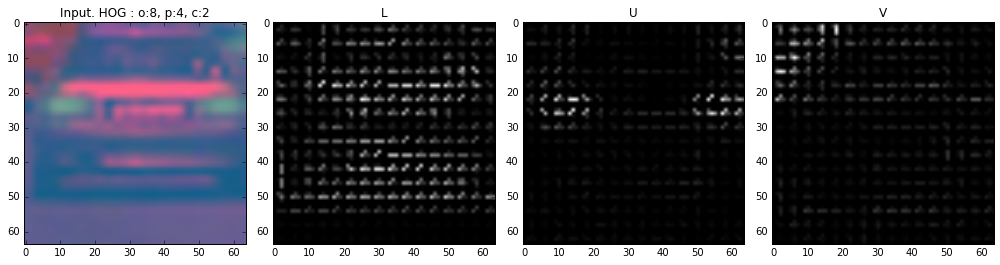

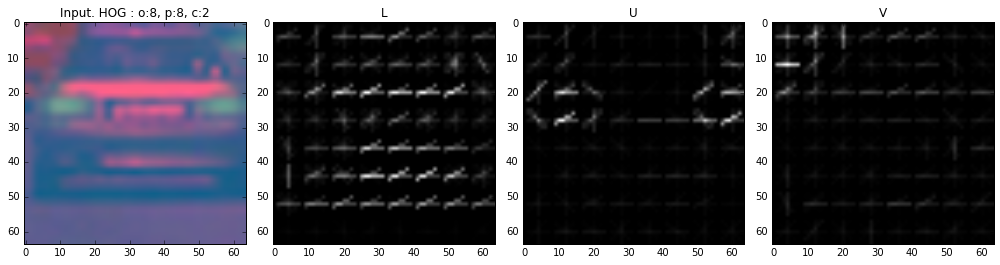

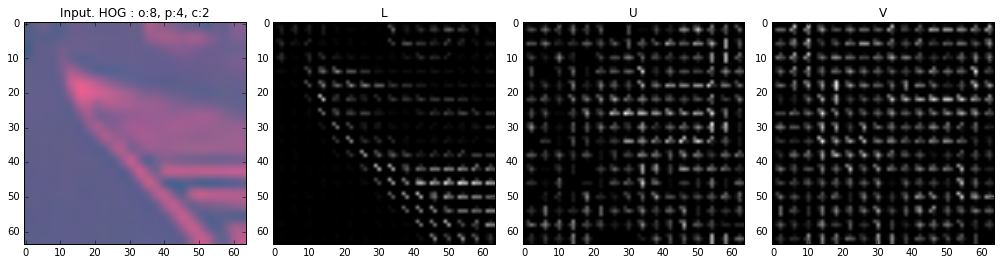

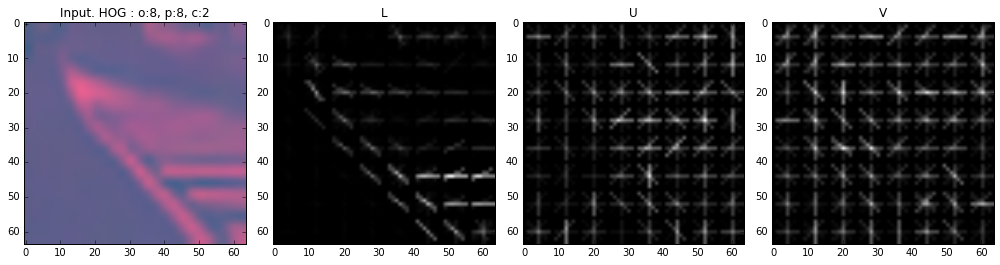

In [29]:
vehicle_example_LUV = cv2.cvtColor(vehicle_example, cv2.COLOR_RGB2LUV)
notvehicle_example_LUV = cv2.cvtColor(notvehicle_example, cv2.COLOR_RGB2LUV)

_orient = [8]
_pix_per_cell = [4, 8]
_cell_per_block = [2]

for test_im in [vehicle_example_LUV, notvehicle_example_LUV]:
    for orient in _orient:
        for pix_per_cell in _pix_per_cell:
            for cell_per_block in _cell_per_block:
                hog_images = [test_im]
                for ch in range(test_im.shape[-1]):
                    features, hog_image = get_hog_features(test_im[:, :, ch], orient, pix_per_cell, cell_per_block,
                                                           vis=True, feature_vec=True)
                    hog_images.append(hog_image)

                U.pim(hog_images, ['Input. HOG : o:{}, p:{}, c:{}'.format(orient, pix_per_cell, cell_per_block),
                                   'L', 'U', 'V'])

# Test : sliding window

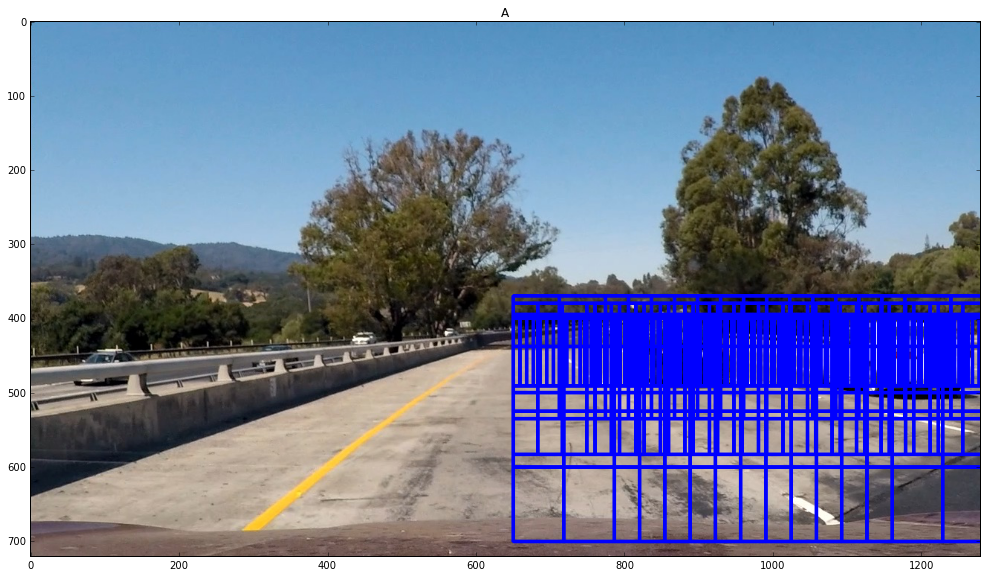

In [34]:
test_image_path = 'test_images/test1.jpg'
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

x_start_stops = [[650, None], [650, None], [650, None], [650, None]] # Min and max in y to search in slide_window()
xy_windows = [(96, 96), (110, 145), (155, 165), (170, 200)] # x, y

y_start_stops = [[395, 530], [380, 590], [370, 590], [400, 700]] # Min and max in y to search in slide_window()
xy_overlaps = [(0.9, 0.5), (0.7, 0.6), (0.6, 0.5), (0.6, 0.5)] # x, y

windows = []
for y_start_stop, x_start_stop, xy_window, xy_overlap in zip(y_start_stops, x_start_stops, xy_windows, xy_overlaps):
    windows += slide_window(test_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                            xy_window=xy_window, xy_overlap=xy_overlap)
    
test_image_windows = draw_boxes(test_image, windows, color=(0, 0, 255), thick=4)

U.pim([test_image_windows], 'All windows')

save_im = cv2.cvtColor(test_image_windows, cv2.COLOR_RGB2BGR)
s = cv2.imwrite("test_image_windows.jpg", save_im)

# Test : detecting cars in image

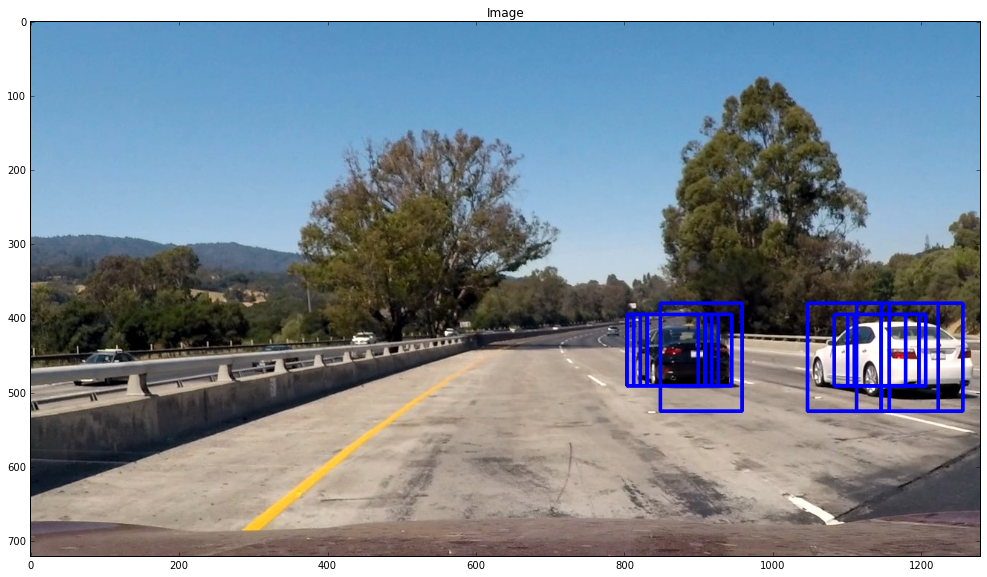

In [42]:
# cars : https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# not cars : https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

# Read in cars and notcars
car_dir_names = ['vehicles/KITTI_extracted/', 'vehicles/GTI_Right/', 'vehicles/GTI_MiddleClose/',
                 'vehicles/GTI_Left/', 'vehicles/GTI_Far/']
notcar_dir_names = ['non-vehicles/Extras/', 'non-vehicles/GTI/']

cars = []
notcars = []

for d in car_dir_names:
    cars += glob.glob(d + '*.png')
for d in notcar_dir_names:
    notcars += glob.glob(d + '*.png')

color_space = 'LUV'
spatial_size = (16, 16)
hist_bins = 16 # Number of histogram bins
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)

hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space, 
                             spatial_size=spatial_size, hist_bins=hist_bins, 
                             orient=orient, pix_per_cell=pix_per_cell, 
                             cell_per_block=cell_per_block, 
                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
                             hist_feat=hist_feat, hog_feat=hog_feat)

test_image_DetectedCars = draw_boxes(test_image, hot_windows, color=(0, 0, 255), thick=4)

U.pim([test_image_DetectedCars])

save_im = cv2.cvtColor(test_image_DetectedCars, cv2.COLOR_RGB2BGR)
s = cv2.imwrite("test_image_detectedcars.jpg", save_im)

# Loading training images

In [65]:
# cars : https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# not cars : https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

# Read in cars and notcars
car_dir_names = ['vehicles/KITTI_extracted/', 'vehicles/GTI_Right/', 'vehicles/GTI_MiddleClose/',
                 'vehicles/GTI_Left/', 'vehicles/GTI_Far/']
notcar_dir_names = ['non-vehicles/Extras/', 'non-vehicles/GTI/']

cars = []
notcars = []

for d in car_dir_names:
    cars += glob.glob(d + '*.png')
for d in notcar_dir_names:
    notcars += glob.glob(d + '*.png')

# Setting main feature parameters

In [66]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
orient = 8  # HOG orientations

spatial_size = (16, 16) # Spatial binning dimensions
cell_per_block = 2 # HOG cells per block
pix_per_cell = 8 # HOG pixels per cell

hist_bins = 16 # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

x_start_stops = [[650, None], [650, None], [650, None], [650, None]] # Min and max in y to search in slide_window()
xy_windows = [(96, 96), (110, 145), (155, 165), (170, 200)] # x, y

y_start_stops = [[395, 530], [380, 590], [370, 590], [400, 700]] # Min and max in y to search in slide_window()
xy_overlaps = [(0.9, 0.5), (0.7, 0.6), (0.6, 0.5), (0.6, 0.5)] # x, y

# Extract features

In [67]:
car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Format data

In [68]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('X_train', end=' ') ; U.basic_info(X_train)
print('X_test', end=' ') ; U.basic_info(X_test)
print('y_train', end=' ') ; U.basic_info(X_train)
print('y_test', end=' ') ; U.basic_info(X_train)

X_train  float64 (14208, 2384) Min -11.0381 Max 68.2066 Mean 0.0006 std 0.9994
X_test  float64 (3552, 2384) Min -10.8727 Max 43.3242 Mean -0.0024 std 0.996
y_train  float64 (14208, 2384) Min -11.0381 Max 68.2066 Mean 0.0006 std 0.9994
y_test  float64 (14208, 2384) Min -11.0381 Max 68.2066 Mean 0.0006 std 0.9994


# Training

In [69]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

# Check the score of the SVC
print('Using:', orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Training time:', round(t2-t, 2))
%timeit round(svc.score(X_test, y_test), 4)

Using: 8 orientations 8 pixels per cell and 2 cells per block
Test Accuracy of SVC =  0.9885
Training time: 5.31
100 loops, best of 3: 10.4 ms per loop


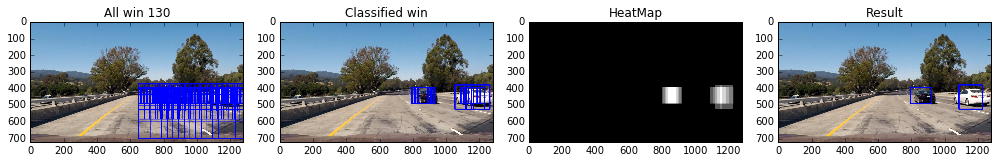

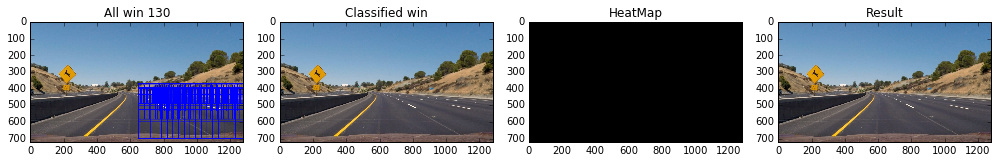

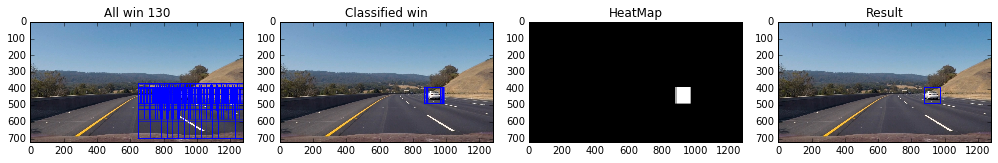

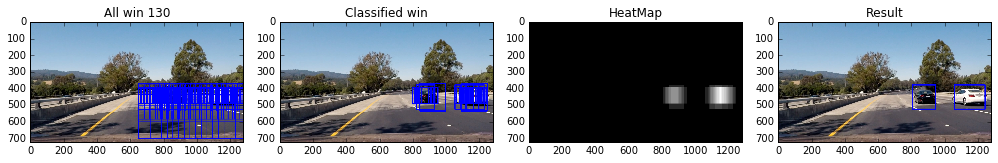

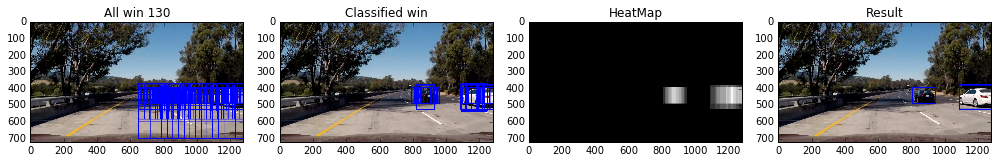

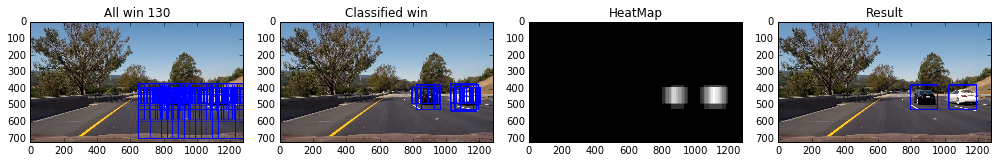

In [75]:
D = detect_cars() # initilize detect_cars class

for i in range(1, 7):
    image_path = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    D.find_cars(image, test=True)

In [76]:
D = detect_cars() # initilize detect_cars class

# Need to initilize lane_finding class before start using pipeline otherwise pipeline will use previously saved values
output = 'test_video_done.mp4'
clip1 = VideoFileClip("test_video.mp4")
done_clip = clip1.fl_image(D.find_cars) #NOTE: this function expects color images!!
%time done_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_done.mp4
[MoviePy] Writing video test_video_done.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  4.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_done.mp4 

CPU times: user 17.2 s, sys: 2.34 s, total: 19.6 s
Wall time: 10.2 s


In [73]:
D = detect_cars() # initilize detect_cars class

# Need to initilize lane_finding class before start using pipeline otherwise pipeline will use previously saved values
output = 'project_video_done.mp4'
clip1 = VideoFileClip("project_video.mp4")
done_clip = clip1.fl_image(D.find_cars) #NOTE: this function expects color images!!
%time done_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_done.mp4
[MoviePy] Writing video project_video_done.mp4


100%|█████████▉| 1260/1261 [05:07<00:00,  3.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_done.mp4 

CPU times: user 9min, sys: 1min 7s, total: 10min 8s
Wall time: 5min 7s
